# G150  Naima tests
* Naima is python package to compute nonthermal emission from a particle population
* It employs the emcee MCMC package to fit the radiative models to data

Bayes' theorem:
$\mathrm{P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)}}$

with:

$\mathrm{P(A \mid B)}$ == Posterior probability (think prob of model given data)

$\mathrm{P(A)}$ == prior 

$\mathrm{\frac{P(B \mid A)} == Likelihood

* emcee use an MCMC method to sample from the posterior distribution to find most likely values for the parameters of the model
* I think what's done is take log of both sides, the normalization parameter, \mathrm{P(B)} is independent of the model, and then the likelihood, $\mathrm{\frac{P(B \mid A)}, is maximized assuming some prior (often a flat prior, not sure what would motivate a different prior like a normally distributed one say)
* Start with some intial guess for parameters, and the MCMC sampler sets up n random walkers to probe the likelihood space, where the values of the next guess only depend on the previous step, to find the maximum likelihood.
* In naiama, we try to find the most likely parameters of some given particle distribution function that give the best fit of the radiative models (which take the particle distibution funcion as input) to our data.
* I think I could flip this and fit params of the radiativ models (like ambient density or magnetic field for sync say) and fix the params of the particle distribution. Or mix too, like fix index of particle distribution, fit magneitic field

In [36]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from astropy import constants as c
import pandas as pd
mpl.style.use('ggplot')
import naima
from naima.models import InverseCompton, Synchrotron, ExponentialCutoffPowerLaw, PionDecay, PowerLaw, Bremsstrahlung
#from sherpa.astro.ui import *
import naima.sherpa_models as smodels
import os, sys

In [2]:
#Setup data
tDir = '/Users/elunejava/Desktop/naimaTest/'
os.chdir(tDir)
G150_data = ascii.read(os.path.join(tDir,'G150_1gev_xgev_yerg_naimaSED.txt'))
#add radio here

## Still not sure what best par are for some functions, try running interactively?
## Not sure how well this will work with no x-ray/TeV emission to constrain fits
## If I include radio, need to include sync (which I don't below) , but it still won't constrain well without x-ray (since no peak, or data on the othe side of the peak)?
## Trying with ECPL, but should I be using PL model for particle distributions since I might don't have info to constrain peaks (need turn overs/breaks in photon data to infer peaks in particle distribution?)?


## Can I use the the same particle population? for e-/p?
## I think what I really want to do is have two particle populations but have the index tied, norm seperate for the two
## issues getting bremss to run, don't need it either right now?


# 1. Just IC

In [118]:
###why not prior for the cutoff? does it just mean I have no clue what the cutoff is? or that I just don't want to limit it?
###do I need to add params?
###this was for norm, inde,cutoff, B right?
def lnprior(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter 
        """
    # Limit norm to be > 0
    logprob = naima.uniform_prior(pars[0], 0., np.inf) \
                + naima.uniform_prior(pars[1], -1, 5)

    return logprob

In [119]:
def electronIC(pars,data):
    """Decide between PL or ECPL model based on number
         of params in pars. Set up e- IC model"""
    #if this function needs to be passed into the model
    #not sure I can have ph fields as a param above
    #same for Eemin and dist
    
    #params not to be fit
    sd_ph = ['CMB','FIR','NIR']
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    
    #define units for params to be fit
    amplitude = 10**pars[0] / u.eV
    alpha = pars[1]
    
    #Instantiate particle distribution
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod = PowerLaw(amplitude, 10. * u.TeV, alpha)
    elif len(pars) == 3:
        #print 'Particle distribution model is ECPL'
        e_cutoff = (10**pars[2]) * u.TeV
        pMod = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
    
    #instantiate IC models
    IC = InverseCompton(pMod,
                    seed_photon_fields=sd_ph,
                    Eemin=ic_eeMin)


    # compute flux at the energies
    model = (IC.flux(data,distance=dist))

    # Save this realization of the particle distribution function
    elec_energy = np.logspace(11, 15, 100) * u.eV
    nelec = pMod(elec_energy)

    We_IC = IC.compute_We(Eemin= ic_eeMin)#1 * u.TeV)
    return model, (elec_energy, nelec), We_IC

In [120]:
#Define params that will go into model and labels for them
p0 = np.array((33, 2.5, np.log10(48.0))) #ECPL for now
if len(p0) == 2:
    labels = ['log10(norm)', 'index']
elif len(p0) ==3:
    labels = ['log10(norm)', 'index', 'log10(cutoff)']

## Run sampler
sampler, pos = naima.run_sampler( data_table=G150_data,
                                 p0=p0,
                                 labels=labels,
                                 model=electronIC,
                                 prior=lnprior,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC', sampler)

INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 31.20921431   2.5          1.68124124]
INFO:astropy:   Initial lnprob(p0): -638.189


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 31.20921431   2.5          1.68124124] [naima.core]
INFO:    Initial lnprob(p0): -638.189 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 30.19989695   1.63877224   2.13198542]
INFO:astropy:   Maximum lnprob(p0): -2.793


:    New ML parameters : [ 30.19989695   1.63877224   2.13198542] [naima.core]
INFO:    Maximum lnprob(p0): -2.793 [naima.core]
Burning in the 32 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.2            1.64            2.13      
  Last ensemble std    :      0.138          0.00789         0.0101     
  Last ensemble lnprob :  avg: -17.126, max: -2.814

Progress of the run: 5 percent (5 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.2            1.64            2.13      
  Last ensemble std    :     0.0912           0.015          0.0192     
  Last ensemble lnprob :  avg: -9.186, max: -2.798

Progress of the run: 10 percent (10 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.2            1.64         

INFO:astropy:Plotting chain of parameter log10(norm)...



                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.2            1.88            2.62      
  Last ensemble std    :      0.107           0.361           0.771     
  Last ensemble lnprob :  avg: -3.629, max: -1.868
INFO: Plotting chain of parameter log10(norm)... [naima.analysis]
INFO

INFO:astropy:-------------------log10(norm)--------------------
          log10(norm) = $30.21 \pm 0.10$
                 norm = $(1.6 \pm 0.4)\times10^{30}$


: -------------------log10(norm)--------------------
          log10(norm) = $30.21 \pm 0.10$
                 norm = $(1.6 \pm 0.4)\times10^{30}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter index...


: Plotting chain of parameter index... [naima.analysis]
INFO

INFO:astropy:----------------------index-----------------------
          index = $1.8 \pm 0.2$


: ----------------------index-----------------------
          index = $1.8 \pm 0.2$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff)...


: Plotting chain of parameter log10(cutoff)... [naima.analysis]
INFO

INFO:astropy:------------------log10(cutoff)-------------------
          log10(cutoff) = $2.5^{+1.0}_{-0.4}$
                 cutoff = $300^{+3000}_{-170}$


: ------------------log10(cutoff)-------------------
          log10(cutoff) = $2.5^{+1.0}_{-0.4}$
                 cutoff = $300^{+3000}_{-170}$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Spectrum...


: Plotting Electron Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Energy Distribution...


: Plotting Electron Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Plotting $W_e (E_e>1\, \mathrm{GeV})$...


: Plotting $W_e (E_e>1\, \mathrm{GeV})$... [naima.analysis]
INFO

INFO:astropy:Saving results table in G150_IC_results.ecsv


: Saving results table in G150_IC_results.ecsv [naima.analysis]


label,median,unc_lo,unc_hi
str72,float64,float64,float64
log10(norm),30.2132275785,0.102456531182,0.0952745704809
norm,1.63391181404e+30,3.43373069982e+29,4.00796553077e+29
index,1.81586872279,0.230636368018,0.260351852385
log10(cutoff),2.47377615149,0.353122416327,0.99963806609
cutoff,297.70044217,165.676184229,2676.83034252
blob2,2.12992856939e+45,6.80145667315e+44,3.01738075373e+45


In [169]:
#my calc of stats
#why aren't they the same as above?
print 'median', np.median(pos,axis = 0)
print 'mean  ', np.mean(pos,axis = 0)
# print pos.min(axis = 0)
# print np.median(pos,axis = 0)-pos.min(axis = 0)


In [90]:
#[log10(norm),norm,index,log10(cutoff),cutoff,blob2] blob2 is We
g150Res['median'][0] #30.2583497988
#g150Res['median']

30.258349798800001

# All the SED below show the median value determine by all the walkers

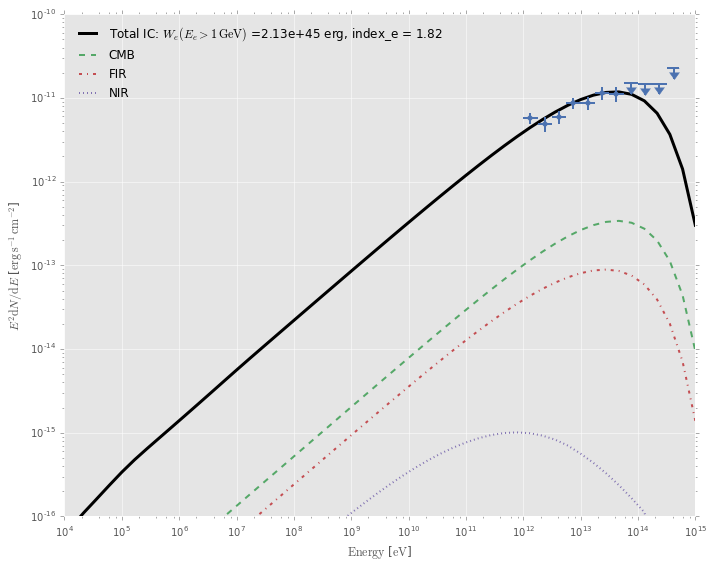

In [28]:
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

#read back in the results
#I should be able to get this from pos, but I don't get the same medians for some reaons
g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
We = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

IC = InverseCompton(ECPL,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c='k', label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_e = %0.2f' %(We,alpha))
for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
    ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
              lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)


ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=False)
figure.tight_layout()
#figure.savefig('G150_IC_SED.png')

# I should maybe not be using ECPL for the electron distribution since I don't know where the peak in the LAT (or TeV) SED is and have no multiwavelngth data? What do other papers do?

# 2. Just PP

In [126]:
def PionDecayMod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay model"""
    #params to fit
    amplitude = 10**pars[0] / u.TeV
    alpha = pars[1]
    e_cutoff = 10**pars[2] * u.TeV
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    
    #Instantiate particle distribution
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod = PowerLaw(amplitude, 10. * u.TeV, alpha)
    elif len(pars) == 3:
        #print 'Particle distribution model is ECPL'
        e_cutoff = (10**pars[2]) * u.TeV
        pMod = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
    #instantiate IC models
    PP = PionDecay(pMod, nh=nh)
    
    #calculate pp flux at energies of data
    model = PP.flux(G150_data, distance=dist)
    
    # Prepare an energy array for saving the particle distribution
    proton_energy = np.logspace(-3, 2, 50) * u.TeV
    
    # Save a realization of the particle distribution to the metadata blob
    proton_dist = PP.particle_distribution(proton_energy)
    
    # Compute the total energy in protons above 1 TeV for this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (proton_energy, proton_dist), Wp



In [127]:
#no reason to not use the same prior as for IC right?
#should I use the same p0 values as for IC? try with the IC ones first to see how it goes?
#PionDecay_ECPL_p0 = np.array((46, 2.34, np.log10(80.)))
PionDecay_ECPL_p0 = p0

if len(p0) == 2:
    labels = ['log10(norm)', 'index']
elif len(p0) ==3:
    labels = ['log10(norm)', 'index', 'log10(cutoff)']

## Run sampler
sampler, pos = naima.run_sampler( data_table=G150_data,
                                 p0=PionDecay_ECPL_p0,
                                 labels=labels,
                                 model=PionDecayMod,
                                 prior=lnprior,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_PP_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_PP',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_PP', sampler)

INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 46.48867502   2.5          1.68124124]


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 46.48867502   2.5          1.68124124] [naima.core]
INFO

INFO:astropy:   Initial lnprob(p0): -2020.528


:    Initial lnprob(p0): -2020.528 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 44.04700351   0.20528688   2.12238335]
INFO:astropy:   Maximum lnprob(p0): -4.872


:    New ML parameters : [ 44.04700351   0.20528688   2.12238335] [naima.core]
INFO:    Maximum lnprob(p0): -4.872 [naima.core]
Burning in the 32 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :       44             0.206           2.13      
  Last ensemble std    :      0.176           0.001          0.0117     
  Last ensemble lnprob :  avg: -22.903, max: -4.839

Progress of the run: 5 percent (5 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :       44             0.205           2.12      
  Last ensemble std    :      0.124          0.00112         0.0358     
  Last ensemble lnprob :  avg: -13.119, max: -4.860

Progress of the run: 10 percent (10 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :       44             0.206       

INFO:astropy:Plotting chain of parameter log10(norm)...


: Plotting chain of parameter log10(norm)... [naima.analysis]
INFO

INFO:astropy:-------------------log10(norm)--------------------
          log10(norm) = $44.3 \pm 0.4$
                 norm = $(2.0^{+3}_{-1.1})\times10^{44}$


: -------------------log10(norm)--------------------
          log10(norm) = $44.3 \pm 0.4$
                 norm = $(2.0^{+3}_{-1.1})\times10^{44}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter index...


: Plotting chain of parameter index... [naima.analysis]
INFO

INFO:astropy:----------------------index-----------------------
          index = $0.6 \pm 0.5$


: ----------------------index-----------------------
          index = $0.6 \pm 0.5$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff)...


: Plotting chain of parameter log10(cutoff)... [naima.analysis]
INFO

INFO:astropy:------------------log10(cutoff)-------------------
          log10(cutoff) = $2.3 \pm 0.2$
                 cutoff = $200^{+130}_{-90}$


: ------------------log10(cutoff)-------------------
          log10(cutoff) = $2.3 \pm 0.2$
                 cutoff = $200^{+130}_{-90}$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Spectrum...


: Plotting Electron Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Energy Distribution...


: Plotting Electron Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Plotting $W_P (E_p>1\, \mathrm{GeV})$...


: Plotting $W_P (E_p>1\, \mathrm{GeV})$... [naima.analysis]
INFO

INFO:astropy:Saving results table in G150_PP_results.ecsv


: Saving results table in G150_PP_results.ecsv [naima.analysis]


label,median,unc_lo,unc_hi
str72,float64,float64,float64
log10(norm),44.2987854561,0.370757396751,0.415556883584
norm,1.9896901781e+44,1.14235841073e+44,3.19046286751e+44
index,0.618333787573,0.565470477226,0.50299424816
log10(cutoff),2.30626821249,0.246439920886,0.22121025403
cutoff,202.426894497,87.6569161081,134.455639666
blob2,1.80212740357e+48,1.69214692503e+47,1.55492288435e+47


In [131]:
np.max(pos,axis =0)

array([ 44.8443502 ,   1.29008476,   2.72751836])

# These are wrong and unnecessary! I loadeed the IC ECPL results and put those into PionDecay by accident!


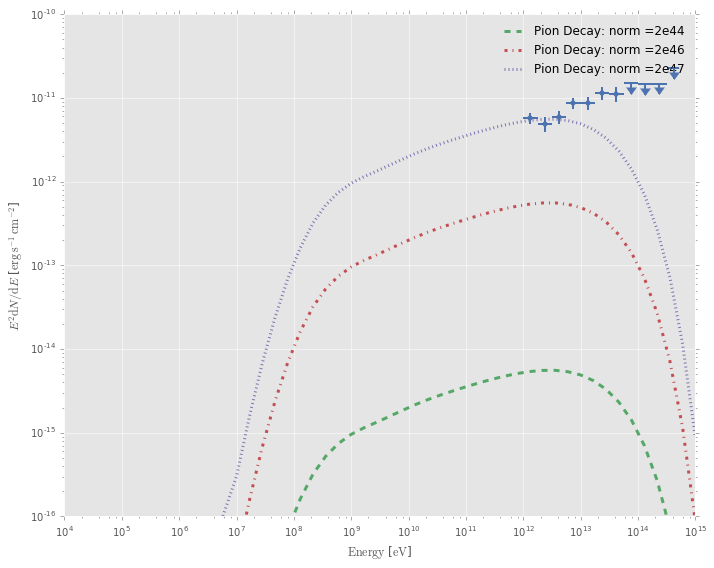

In [140]:

# #try plotting PP for other values I supply 
# #plot SED with best fit electron spec and data

# #different norms

# fig = plt.figure(figsize = [10,8])
# figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
# ax = figure.axes[0]


# g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
# amplitude = [10**g150Res['median'][0] / u.eV,(100*10**g150Res['median'][0] / u.eV),(1000*10**g150Res['median'][0] / u.eV)]
# alpha = g150Res['median'][2]
# e_cutoff = (10**g150Res['median'][3]) * u.TeV


# ECPL = [ExponentialCutoffPowerLaw(a, 10. * u.TeV, alpha, e_cutoff) for a in amplitude]
# PP = [PionDecay(ec, nh=1*u.cm**-3) for ec in ECPL]

# energy = np.logspace(-7, 15, 100) * u.eV

# for pp,i,l,ls in zip(PP, range(4),['Pion Decay: norm =2e44','Pion Decay: norm =2e46','Pion Decay: norm =2e47'],['--', '-.', ':']):
#     ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
#              lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)


# ax.set_ylim(1e-16, 1e-10)
# ax.set_xlim(1e4)
# ax.legend(loc='upper right', frameon=False)
# figure.tight_layout()
# #figure.savefig('G150_PP_SED.png')

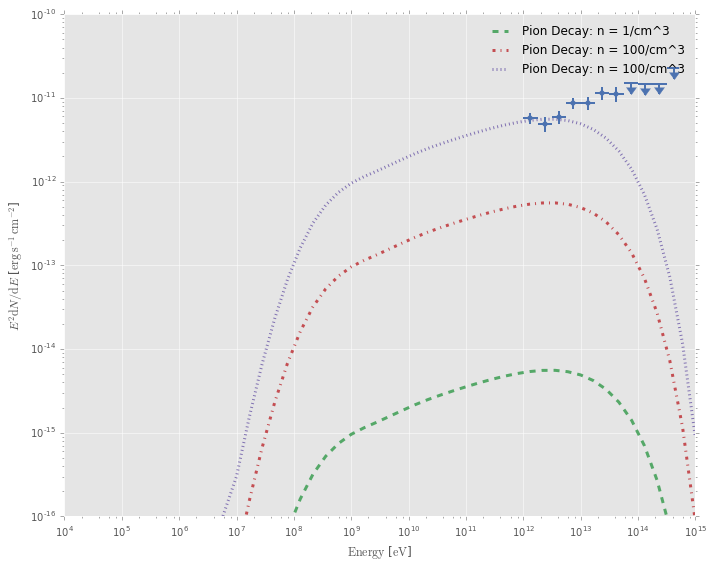

In [138]:
#These are wrong and unnecessary!
#i loadeed the IC ECPL results and put those into PionDecay by accident!

#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]


g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV

ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

PP = [PionDecay(ECPL, nh=1*u.cm**-3),PionDecay(ECPL, nh=100*u.cm**-3),PionDecay(ECPL, nh=1000*u.cm**-3)]
# PP1 = PionDecay(ECPL, nh=1*u.cm**-3)
# PP100 = PionDecay(ECPL, nh=100*u.cm**-3)
# pp1000 = PionDecay(ECPL, nh=1000*u.cm**-3)
# Plot the computed model emission

energy = np.logspace(-7, 15, 100) * u.eV

for pp,i,l,ls in zip(PP, range(4),['Pion Decay: n = 1/cm^3','Pion Decay: n = 100/cm^3','Pion Decay: n = 100/cm^3'],['--', '-.', ':']):
    ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
             lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)


ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='upper right', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# Here are the good results!

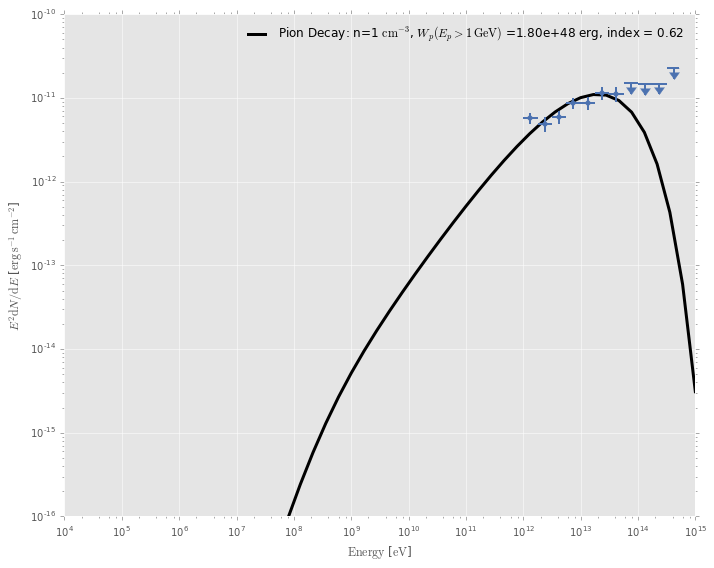

In [32]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]
g150Res = ascii.read(os.path.join(tDir,'G150_PP_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.TeV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
Wp = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

nh = 1*u.cm**-3
PP = PionDecay(ECPL, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c='k', label='Pion Decay: n=1 $\mathrm{cm}^{-3}$, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index = %0.2f' %(Wp,alpha))

# for pp,i,l,ls in zip(PP, range(4),['Pion Decay: n = 1/cm^3','Pion Decay: n = 100/cm^3','Pion Decay: n = 100/cm^3'],['--', '-.', ':']):
#     ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
#              lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)

ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

## Show best fit separate IC/PP models overlaid

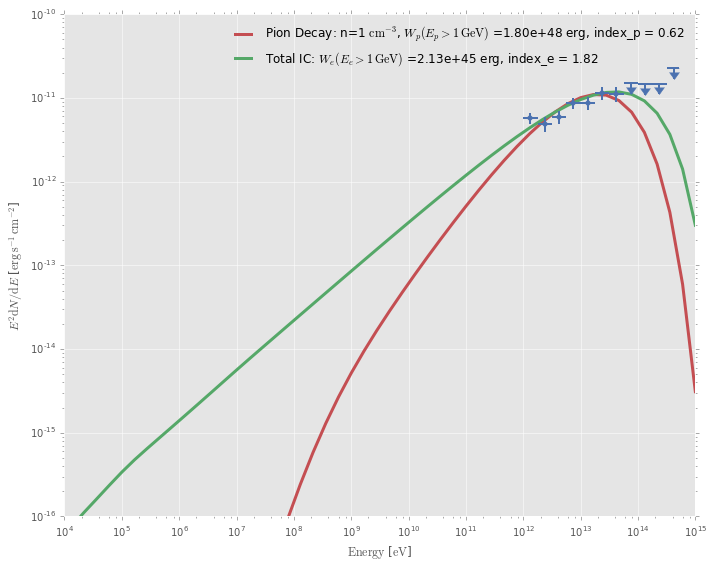

In [34]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

###First PP
g150Res = ascii.read(os.path.join(tDir,'G150_PP_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.TeV
alpha = alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
Wp = g150Res['median'][5]

ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

nh = 1*u.cm**-3
PP = PionDecay(ECPL, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[2], label='Pion Decay: n=1 $\mathrm{cm}^{-3}$, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_p = %0.2f' %(Wp,alpha))

###Now IC
g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
We = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

IC = InverseCompton(ECPL,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[1], label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_e = %0.2f' %(We,alpha))
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)

ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='upper right', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# Are the total energies in We, Wp reasonable?
# What about indices for each particle distribution?
## I think pp is way too hard?

# 3. IC + PP

In [5]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.39 *u.kpc
    
    #params to fit for PP and IC
    #p0 = np.arra((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    amplitude_IC = 10**pars[0] / u.TeV
    amplitude_PP = 10**pars[1] / u.TeV
    alpha = pars[2] #same index for both

    
    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_IC = PowerLaw_IC(amplitude_IC, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw_PP(amplitude_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_IC = (10**pars[3]) * u.TeV
        pMod_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_IC,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_eeMin)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data,
                     distance=dist) + PP.flux(G150_data, distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_IC(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(eneegy?)

    # Compute the total energy in protons/electrons above 1 GeVfor this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_IC_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_IC, norm_PP, index. Not cutoffs
        """

    logprob = naima.uniform_prior(pars[0], 0., np.inf)          \
                    + naima.uniform_prior(pars[1],0., np.inf)      \
                    + naima.uniform_prior(pars[2], -1, 5) 

    return logprob

INFO:astropy:Launching interactive model fitter, close window when finished


INFO: Launching interactive model fitter, close window when finished [naima.core]


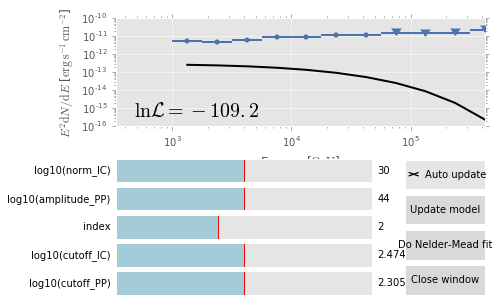

INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 30.          44.           2.           2.47421626   2.30535137]


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 30.          44.           2.           2.47421626   2.30535137] [naima.core]
INFO

INFO:astropy:   Initial lnprob(p0): -109.153


:    Initial lnprob(p0): -109.153 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 40.61043197  44.85778305   1.47029176   1.55635186   3.057782  ]
INFO:astropy:   Maximum lnprob(p0): -2.214


:    New ML parameters : [ 40.61043197  44.85778305   1.47029176   1.55635186   3.057782  ] [naima.core]
INFO:    Maximum lnprob(p0): -2.214 [naima.core]
Burning in the 32 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           log10(norm_IC)- log10(amplitude_PP) -----index----- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      40.6            44.9            1.47            1.56            3.05      
  Last ensemble std    :      0.198           0.173          0.00869         0.00832         0.0133     
  Last ensemble lnprob :  avg: -35.771, max: -2.312

Progress of the run: 5 percent (5 of 100 steps)
                           log10(norm_IC)- log10(amplitude_PP) -----index----- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      40.6            44.9            1.47            1.56            3.05      
  Last ensemble std    :      0.21            0.118          0.0143          0.0149           0.02      
  Last

INFO:astropy:Plotting chain of parameter log10(norm_IC)...



                           log10(norm_IC)- log10(amplitude_PP) -----index----- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      36.5             45             1.66            1.35            3.33      
  Last ensemble std    :      44.4            0.351           0.339           9.57            0.482     
  Last ensemble lnprob :  avg: -3.044, max: -1.038
INFO: Plotting chain of parameter log10(norm_IC)... [naima.analysis]
INFO

INFO:astropy:------------------log10(norm_IC)------------------
          log10(norm_IC) = $36^{+11}_{-20}$
                 norm_IC = $(1.8^{+140000000000}_{-1.8})\times10^{36}$


: ------------------log10(norm_IC)------------------
          log10(norm_IC) = $36^{+11}_{-20}$
                 norm_IC = $(1.8^{+140000000000}_{-1.8})\times10^{36}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(amplitude_PP)...


: Plotting chain of parameter log10(amplitude_PP)... [naima.analysis]
INFO

INFO:astropy:---------------log10(amplitude_PP)----------------
          log10(amplitude_PP) = $44.92^{+0.18}_{-0.4}$
                 amplitude_PP = $(8 \pm 5)\times10^{44}$


: ---------------log10(amplitude_PP)----------------
          log10(amplitude_PP) = $44.92^{+0.18}_{-0.4}$
                 amplitude_PP = $(8 \pm 5)\times10^{44}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter index...


: Plotting chain of parameter index... [naima.analysis]
INFO

INFO:astropy:----------------------index-----------------------
          index = $1.55^{+0.20}_{-0.4}$


: ----------------------index-----------------------
          index = $1.55^{+0.20}_{-0.4}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_IC)...


: Plotting chain of parameter log10(cutoff_IC)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $1 \pm 3$
                 cutoff_IC = $20^{+30000}_{-20}$


: -----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $1 \pm 3$
                 cutoff_IC = $20^{+30000}_{-20}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_PP)...


: Plotting chain of parameter log10(cutoff_PP)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $3.3 \pm 0.5$
                 cutoff_PP = $(2.0^{+4}_{-1.3})\times10^{3}$


: -----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $3.3 \pm 0.5$
                 cutoff_PP = $(2.0^{+4}_{-1.3})\times10^{3}$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Spectrum...


: Plotting Proton Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Energy Distribution...


: Plotting Proton Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Plotting $W_p (E_p>1\, \mathrm{GeV})$...


: Plotting $W_p (E_p>1\, \mathrm{GeV})$... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Spectrum...


: Plotting Electron Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Energy Distribution...


: Plotting Electron Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Saving results table in G150_IC_PP_results.ecsv


: Saving results table in G150_IC_PP_results.ecsv [naima.analysis]


label,median,unc_lo,unc_hi
str72,float64,float64,float64
log10(norm_IC),36.2459770417,19.5638522225,10.8396776421
norm_IC,1.76188290492e+36,1.76188290492e+36,1.36988450023e+47
log10(amplitude_PP),44.9201368737,0.378841484982,0.177565297246
amplitude_PP,8.32025953896e+44,4.84141508615e+44,4.20256140624e+44
index,1.55376055777,0.372148386601,0.195380960471
log10(cutoff_IC),1.36780521872,2.73013232191,3.14363287642
cutoff_IC,23.3241173991,23.2806990909,32443.3719277
log10(cutoff_PP),3.29318969328,0.475196551409,0.454434838201
cutoff_PP,1964.21803029,1306.57057821,3628.98537438


In [6]:
#I think if I only pass in pars for one amp/ind/cutoff it won't fit two different
#maybe I can't pass in more labels than pars?
#is it possible to use only a single index par/label?
###Is there no such thing as a joint fit of elec and prot spec in naima?
###or maybe naima is smart and I can like this?


#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((30, 44, 2., np.log10(298),np.log10(202))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_IC)', 'log10(amplitude_PP)', 'index']
elif len(p0) ==5:
    labels = ['log10(norm_IC)', 'log10(amplitude_PP)', 'index', 'log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
sampler, pos = naima.run_sampler(data_table=G150_data,
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Mod,
                                 prior=lnprior_IC_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_PP_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC_PP',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC_PP', sampler)


In [8]:
#Read in data, see what it looks like
g150Res_IC_PP = ascii.read(os.path.join(tDir,'G150_IC_PP_results.ecsv'))
g150Res_IC_PP

label,median,unc_lo,unc_hi
str19,float64,float64,float64
log10(norm_IC),36.2459770417,19.5638522225,10.8396776421
norm_IC,1.76188290492e+36,1.76188290492e+36,1.36988450023e+47
log10(amplitude_PP),44.9201368737,0.378841484982,0.177565297246
amplitude_PP,8.32025953896e+44,4.84141508615e+44,4.20256140624e+44
index,1.55376055777,0.372148386601,0.195380960471
log10(cutoff_IC),1.36780521872,2.73013232191,3.14363287642
cutoff_IC,23.3241173991,23.2806990909,32443.3719277
log10(cutoff_PP),3.29318969328,0.475196551409,0.454434838201
cutoff_PP,1964.21803029,1306.57057821,3628.98537438


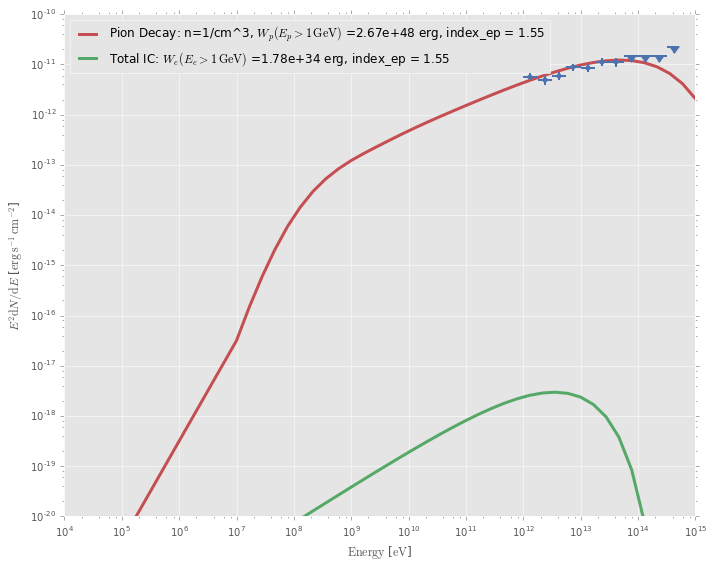

In [35]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

###First PP
amplitude_PP = 10**g150Res_IC_PP['median'][2] / u.TeV
alpha = alpha = g150Res_IC_PP['median'][4]
e_cutoff_PP = (10**g150Res_IC_PP['median'][7]) * u.TeV
Wp = g150Res_IC_PP['median'][9]

ECPL_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh = 1*u.cm**-3
PP = PionDecay(ECPL_PP, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[2], label='Pion Decay: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f' %(Wp,alpha))

###Now IC
amplitude_IC = 10**g150Res_IC_PP['median'][0] / u.TeV
e_cutoff_IC = (10**g150Res_IC_PP['median'][5]) * u.TeV
We = g150Res_IC_PP['median'][10]
ECPL_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)

IC = InverseCompton(ECPL_IC,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[1], label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f' %(We,alpha))
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)

ax.set_ylim(1e-20, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=True)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# If I wanted to plot the error just use the low and high vals (which I think are the 16/84th percentiles?

# How does the above change if I use different starting values?
* Like If I start with a higher norm for IC does it find a different fit where the IC is more dominant?


# Do the results just mean that the data doesn't require a mixed model to fit?
* Why such different index for the IC/PP model vs just PP?
* Having both 

# Try fitting with different index for PP/IC

In [40]:
def IC_PP_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.39 *u.kpc
    
    #params to fit for PP and IC
    #p0 = np.arra((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    amplitude_IC = 10**pars[0] / u.TeV
    amplitude_PP = 10**pars[1] / u.TeV
    alpha_IC = pars[2]
    alpha_PP = pars[3]

    
    #Instantiate particle distributions for IC and PP
    if len(pars) == 4:
        #print 'Particle distribution model is PL'
        pMod_IC = PowerLaw_IC(amplitude_IC, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw_PP(amplitude_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 6:
        #print 'Particle distribution model is ECPL'
        e_cutoff_IC = (10**pars[4]) * u.TeV
        pMod_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)
        e_cutoff_PP = (10**pars[5]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_IC,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_eeMin)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data,
                     distance=dist) + PP.flux(G150_data, distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_IC(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(eneegy?)

    # Compute the total energy in protons/electrons above 1 GeVfor this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_IC_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_IC, norm_PP, index. Not cutoffs
        """

    logprob = naima.uniform_prior(pars[0], 0., np.inf)       \
                    + naima.uniform_prior(pars[1],0., np.inf) \
                    + naima.uniform_prior(pars[2], -1, 5)     \
                    + naima.uniform_prior(pars[3], -1, 5) 

    return logprob

INFO:astropy:Launching interactive model fitter, close window when finished


INFO: Launching interactive model fitter, close window when finished [naima.core]


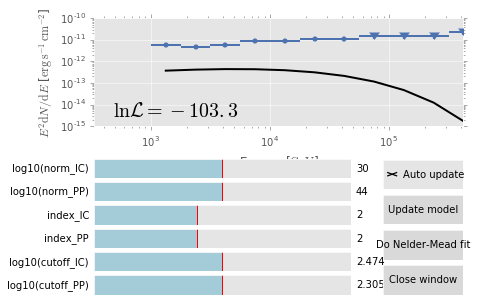

INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 30.          44.           2.           2.           2.47421626
   2.30535137]


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 30.          44.           2.           2.           2.47421626
   2.30535137] [naima.core]
INFO

INFO:astropy:   Initial lnprob(p0): -103.254


:    Initial lnprob(p0): -103.254 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 23.05128202  44.90382791   1.83126565   1.76769156   2.67949897
   3.28515431]
INFO:astropy:   Maximum lnprob(p0): -1.956


:    New ML parameters : [ 23.05128202  44.90382791   1.83126565   1.76769156   2.67949897
   3.28515431] [naima.core]
INFO:    Maximum lnprob(p0): -1.956 [naima.core]
Burning in the 32 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           log10(norm_IC)- log10(norm_PP)- ---index_IC---- ---index_PP---- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      23.1            44.9            1.83            1.77            2.68            3.28      
  Last ensemble std    :      0.105           0.194          0.00888         0.0135          0.0188          0.0215     
  Last ensemble lnprob :  avg: -68.304, max: -1.976

Progress of the run: 5 percent (5 of 100 steps)
                           log10(norm_IC)- log10(norm_PP)- ---index_IC---- ---index_PP---- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      23.1            44.9            1.83            1.77            2.67            3.28      
  Last ensemble std    : 


                           log10(norm_IC)- log10(norm_PP)- ---index_IC---- ---index_PP---- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      26.2            44.9            1.79            2.21           -0.644           3.27      
  Last ensemble std    :      33.4           0.0804           1.62            2.01            14.9            0.305     
  Last ensemble lnprob :  avg: -3.028, max: -1.980
INFO

INFO:astropy:Plotting chain of parameter log10(norm_IC)...


: Plotting chain of parameter log10(norm_IC)... [naima.analysis]
INFO

INFO:astropy:------------------log10(norm_IC)------------------
          log10(norm_IC) = $30^{+30}_{-20}$
                 norm_IC = $(4^{+19999999999999998911504619740856320}_{-4})\times10^{30}$


: ------------------log10(norm_IC)------------------
          log10(norm_IC) = $30^{+30}_{-20}$
                 norm_IC = $(4^{+19999999999999998911504619740856320}_{-4})\times10^{30}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(norm_PP)...


: Plotting chain of parameter log10(norm_PP)... [naima.analysis]
INFO

INFO:astropy:------------------log10(norm_PP)------------------
          log10(norm_PP) = $44.91^{+0.05}_{-0.09}$
                 norm_PP = $(8.2^{+1.0}_{-1.5})\times10^{44}$


: ------------------log10(norm_PP)------------------
          log10(norm_PP) = $44.91^{+0.05}_{-0.09}$
                 norm_PP = $(8.2^{+1.0}_{-1.5})\times10^{44}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter index_IC...


: Plotting chain of parameter index_IC... [naima.analysis]
INFO

INFO:astropy:---------------------index_IC---------------------
          index_IC = $1.8^{+1.3}_{-2}$


: ---------------------index_IC---------------------
          index_IC = $1.8^{+1.3}_{-2}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter index_PP...


: Plotting chain of parameter index_PP... [naima.analysis]
INFO

INFO:astropy:---------------------index_PP---------------------
          index_PP = $2 \pm 2$


: ---------------------index_PP---------------------
          index_PP = $2 \pm 2$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_IC)...


: Plotting chain of parameter log10(cutoff_IC)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $-2^{+9}_{-16}$
                 cutoff_IC = $0.02^{+18000000}_{-0.02}$


: -----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $-2^{+9}_{-16}$
                 cutoff_IC = $0.02^{+18000000}_{-0.02}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_PP)...


: Plotting chain of parameter log10(cutoff_PP)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $3.3^{+0.4}_{-0.2}$
                 cutoff_PP = $(1.8^{+3}_{-0.8})\times10^{3}$


: -----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $3.3^{+0.4}_{-0.2}$
                 cutoff_PP = $(1.8^{+3}_{-0.8})\times10^{3}$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Spectrum...


: Plotting Proton Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Energy Distribution...


: Plotting Proton Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Plotting $W_p (E_p>1\, \mathrm{GeV})$...


: Plotting $W_p (E_p>1\, \mathrm{GeV})$... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Spectrum...


: Plotting Electron Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Energy Distribution...


: Plotting Electron Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Saving results table in G150_IC_PP_difInd_results.ecsv


: Saving results table in G150_IC_PP_difInd_results.ecsv [naima.analysis]


label,median,unc_lo,unc_hi
str72,float64,float64,float64
log10(norm_IC),30.6291053405,24.8788166412,33.7127734548
norm_IC,4.25701656917e+30,4.25701656917e+30,2.19724657078e+64
log10(norm_PP),44.9145692932,0.0898635669138,0.0493141732888
norm_PP,8.21428690836e+44,1.53535230961e+44,9.87739314277e+43
index_IC,1.82670741205,2.05430381797,1.27556020033
index_PP,1.92619424033,2.39645426393,2.05711469734
log10(cutoff_IC),-1.63766836036,16.2290790118,8.89168401201
cutoff_IC,0.0230319993515,0.0230319993515,17947983.0656
log10(cutoff_PP),3.25367810199,0.237254919545,0.380919254401


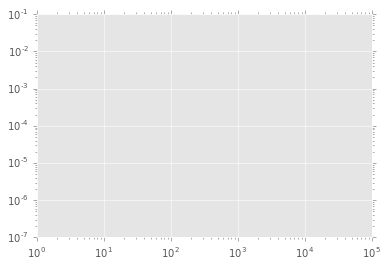

In [41]:
#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((30, 44, 2.,2, np.log10(298),np.log10(202))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 4:
    labels = ['log10(norm_IC)', 'log10(norm_PP)', 'index_IC','index_PP']
elif len(p0) ==6:
    labels = ['log10(norm_IC)', 'log10(norm_PP)', 'index_IC', 'index_PP', 'log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
sampler, pos = naima.run_sampler(data_table=G150_data,
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Mod,
                                 prior=lnprior_IC_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_PP_diffInd_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC_PP_difInd',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC_PP_difInd', sampler)


# Don't bother plotting the above, the results look strange/bad
* Is something wrong with the setup or is there too much degeneracy between the params?


# What about using a  PL particle distribution?

# What about using the interactive fitter to get the best fit params?
* Doesn't work right inside the notebook, even if I use %matplotlib notebook or qt (maybe I have to kill the server and restart it?

# Add in radio SED from Gerbrandt et al. 2014?
* how do they  get the full and partial?

# Include the 2FHL result?
* maybe not fair to include since it looks like a different source?

# I started runs fixing the size of the source to the  >1 GeV result, and fitting down to 237 MeV (any reason not to? PSF at this energy is larger than the sigma of the extended source, but that shouldn't matter since I fix the extent right?
* do these runs look ok?
* maybe help to constrain spectra?